In [11]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker


import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import loadmat,savemat
from training_samples import trainingdata_uvw,trainingdata_T



#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

device = device1

Device 1:  cuda:0
Device 2:  cuda:1


In [12]:
R0 = 5 #mm
Rs = 19 #mm
# mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
# delta = 0.5
A = 6.41 #For slip factor
pi = np.pi
Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/N
# A = np.exp(27.78)
log_A = 27.78
n = 3.49
k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 2700 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])

lb_xyz_uvw = np.array([-20.0,-20.0,-3.0])
ub_xyz_uvw = np.array([20.0,20.0,0.0])


In [13]:
def train_step(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat):
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat)
        loss.backward()

        return loss

    optimizer.step(closure)

In [14]:
def train_model(max_iter,rep,n_batches):
    print(rep)
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0

    xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot = trainingdata_uvw(N_B,N_f,lb_xyz,ub_xyz,rep*123)
    xyz_coll = torch.from_numpy(xyz_coll).float().to(device)
    xyz_1 = torch.from_numpy(xyz_1).float().to(device)
    xyz_2 = torch.from_numpy(xyz_2).float().to(device)
    xyz_3 = torch.from_numpy(xyz_3).float().to(device)
    xyz_4 = torch.from_numpy(xyz_4).float().to(device)
    
    xyz_top = torch.from_numpy(xyz_top).float().to(device)
    xyz_bot = torch.from_numpy(xyz_bot).float().to(device)
   
    f_hat = torch.zeros(xyz_coll.shape[0],1).to(device)
    N_hat = torch.zeros(xyz_top.shape[0],1).to(device)


    #Batching only Collocation and f_hat for now
    
    batch_size_coll = int(xyz_coll.shape[0]/n_batches)
    batch_size_top = int(xyz_top.shape[0]/n_batches)

    batch_size_sides = int(xyz_1.shape[0]/n_batches)
    batch_size_bot = int(xyz_bot.shape[0]/n_batches)

    xyz_coll_batches = torch.split(xyz_coll,batch_size_coll)
    f_hat_batches = torch.split(f_hat,batch_size_coll)
    
    xyz_top_batches = torch.split(xyz_top,batch_size_top)
    N_hat_batches = torch.split(N_hat,batch_size_top)

    xyz_1_batches = torch.split(xyz_1,batch_size_sides)
    xyz_2_batches = torch.split(xyz_2,batch_size_sides)
    xyz_3_batches = torch.split(xyz_3,batch_size_sides)
    xyz_4_batches = torch.split(xyz_4,batch_size_sides)
    
    xyz_bot_batches = torch.split(xyz_4,batch_size_bot)
    


    
    for i in range(max_iter):
#         if(i>0 and i%50==0):
#             _,_,_,_,_,xyz_top,xyz_bot = trainingdata(N_B,N_f,i*123)
#             # xyz_coll = torch.from_numpy(xyz_coll).float().to(device)
#             # xyz_1 = torch.from_numpy(xyz_1).float().to(device)
#             # xyz_2 = torch.from_numpy(xyz_2).float().to(device)
#             # xyz_3 = torch.from_numpy(xyz_3).float().to(device)
#             # xyz_4 = torch.from_numpy(xyz_4).float().to(device)

#             xyz_top = torch.from_numpy(xyz_top).float().to(device)
#             xyz_bot = torch.from_numpy(xyz_bot).float().to(device)

        for b in range(n_batches):
            train_step(xyz_coll_batches[b],xyz_1_batches[b], xyz_2_batches[b], xyz_3_batches[b], xyz_4_batches[b],xyz_top_batches[b],xyz_bot_batches[b],f_hat_batches[b],N_hat_batches[b])
            

        # train_step(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat)
        # loss_np = PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat).cpu().detach().numpy()
        # print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        loss_np = PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat).cpu().detach().numpy()
        print(i,"Train Loss",loss_np)

        # if(i>0 and i%25 ==0):
        #   pretrain(xyt_DBC,p_iters)


    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [15]:
from Seq_model import Sequentialmodel
label = 'meltpool'
max_reps = 1
max_iter = 100
p_iters = 10

N_B = 6000
N_f = 10000
n_batches = 5

train_loss_full = []
test_mse_full = []
test_re_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):

    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    torch.manual_seed(reps*3)
     #Total number of collocation points


    layers1 = np.array([3,50,50,50,4]) #9 hidden layers
    layers2 = np.array([3,50,50,50,1]) #9 hidden layers
    # layers = np.array([3,50,50,50,50,50,5])
    # layers = np.array([3,64,64,64,1])
    PINN = Sequentialmodel(layers1,layers2,lb_xyz,ub_xyz)
    # PINN = nn.DataParallel(PINN)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())

    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25,
                              max_iter = 30,
                              max_eval = 50,
                              tolerance_grad = 1e-5,
                              tolerance_change = 1e-5,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')


    start_time = time.time()
    train_model(max_iter,reps,n_batches)


    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)


    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

cuda:0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 219.35498
1 Train Loss 141.17049
2 Train Loss 124.05739
3 Train Loss 101.542404
4 Train Loss 93.66334
5 Train Loss 88.0727
6 Train Loss 93.170944
7 Train Loss 99.29963
8 Train Loss 102.88374
9 Train Loss 102.86791
10 Train Loss 102.24359
11 Train Loss 103.73374
12 Train Loss 101.269485


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 9.97 GiB already allocated; 13.06 MiB free; 9.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
A = torch.normal(mean=0, std=torch.arange(1, 0, -0.08)).reshape(-1,1)

In [ ]:
A.shape[0]

13

torch.Size([2, 1])

In [ ]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -20.0
x_max = 20.0

x = np.linspace(x_min,x_max,100).reshape(-1,1)
y = np.linspace(y_min,y_max,100).reshape(-1,1)
#z = np.linspace(z_min,z_max,20).reshape(-1,1)
z = -0.125

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device)

uvwp = PINN.forward1(xyz_test_tensor).cpu().detach().numpy()

Text(0, 0.5, '$y$')

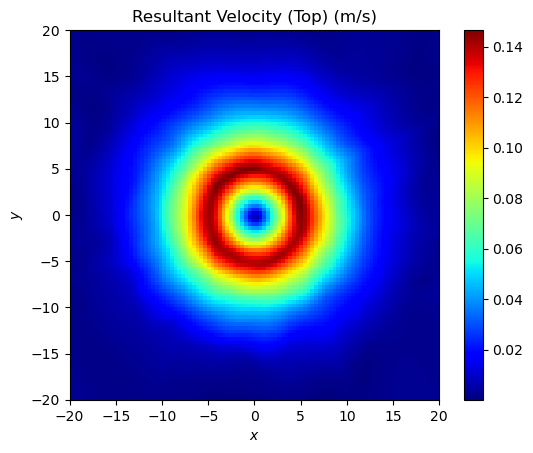

In [ ]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(100,100),cmap = 'jet',extent = [-20,20,-20,20])
fig.colorbar(im)
ax.set_title('Resultant Velocity (Top) (m/s)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# plt.savefig('Res_u_top_Feb7.svg',format = 'svg',bbox_inches = 'tight')

In [ ]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = PINN.forward1(g) 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = PINN.forward2(g)

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


In [ ]:
print(torch.__version__)

1.9.0+cu102


Text(0, 0.5, '$y$')

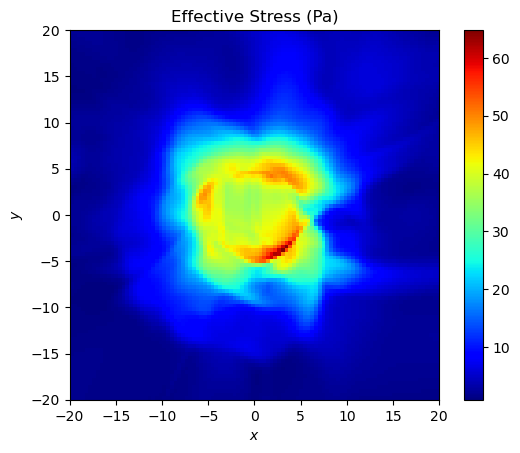

In [ ]:
fig,ax = plt.subplots()
im = ax.imshow(eps_e.reshape(100,100),cmap = 'jet',extent = [-20,20,-20,20])
fig.colorbar(im)
ax.set_title('Effective Stress (Pa)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# plt.savefig('Viscosity_Feb7.svg',format = 'svg',bbox_inches = 'tight')

In [ ]:
x = np.linspace(x_min,x_max,100).reshape(-1,1)
y =0
z = np.linspace(z_min,z_max,20).reshape(-1,1)
# z = z_max

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device)

uvwp = PINN.forward1(xyz_test_tensor).cpu().detach().numpy()

Text(0, 0.5, '$z$')

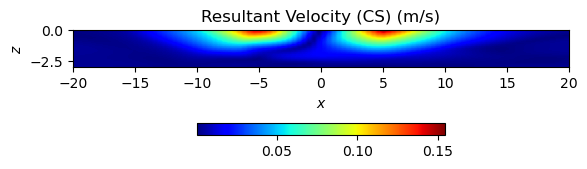

In [ ]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
fig,ax = plt.subplots()
im = ax.imshow(np.flip((r_vel/1000).reshape(20,100)),cmap = 'jet',extent = [-20,20,-3,0])
fig.colorbar(im,orientation = 'horizontal',shrink = 0.5)
ax.set_title('Resultant Velocity (CS) (m/s)')
ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
# plt.savefig('Res_u_Front_Feb7.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$')

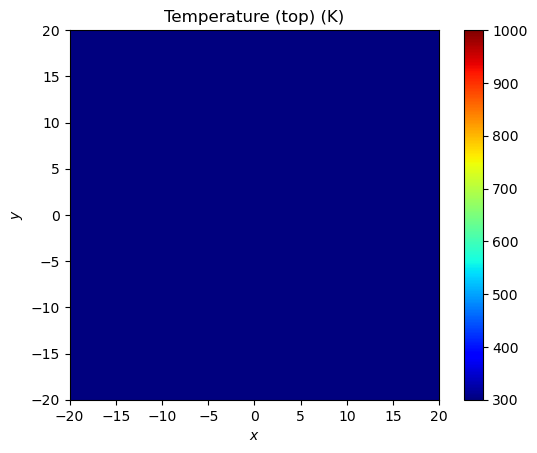

In [ ]:
x = np.linspace(x_min,x_max,100).reshape(-1,1)
y = np.linspace(y_min,y_max,100).reshape(-1,1)
#z = np.linspace(z_min,z_max,20).reshape(-1,1)
z = -0.125

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device)

T = PINN.forward2(xyz_test_tensor).cpu().detach().numpy()
fig,ax = plt.subplots()
im = ax.imshow(T.reshape(100,100),cmap = 'jet',extent = [-20,20,-20,20],vmax = 1000,vmin =300)
fig.colorbar(im)
ax.set_title('Temperature (top) (K)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# plt.savefig('Temp_top_Feb7.svg',format = 'svg',bbox_inches = 'tight')
# plt.scatter(X,Y,c=T,cmap = 'jet')

In [ ]:
np.min(T)

81.517006

Text(0, 0.5, '$z$')

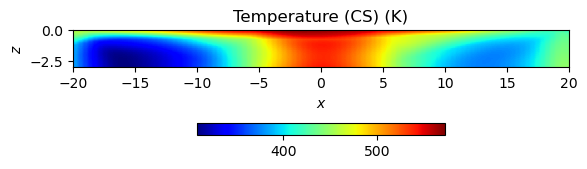

In [ ]:
x = np.linspace(x_min,x_max,100).reshape(-1,1)
y =0
z = np.linspace(z_min,z_max,20).reshape(-1,1)
# z = z_max

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device)

uvwp = PINN.forward1(xyz_test_tensor).cpu().detach().numpy()

T = PINN.forward2(xyz_test_tensor).cpu().detach().numpy()
fig,ax = plt.subplots()
im = ax.imshow(np.flip(T.reshape(20,100)),cmap = 'jet',extent = [-20,20,-3,0])
fig.colorbar(im,orientation = 'horizontal',shrink = 0.5)
ax.set_title('Temperature (CS) (K)')
ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
# plt.savefig('Temp_CS_Feb7.svg',format = 'svg',bbox_inches = 'tight')
# plt.scatter(X,Y,c=T,cmap = 'jet

In [ ]:
min(T)

array([307.42508], dtype=float32)

In [ ]:
xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot = trainingdata(N_B,N_f,123)
    
r = np.sqrt(np.square(xyz_top[:,0]) + np.square(xyz_top[:,1]))
        
r_fr = (r<R0).reshape(-1,1)
r_ph = np.logical_and(r>=R0,r<=Rs).reshape(-1,1)
r_out = np.logical_not(r<=Rs).reshape(-1,1)

cos_theta = xyz_top[:,1]/r #
sin_theta = xyz_top[:,0]/r #

r = r.reshape(-1,1)
cos_theta = cos_theta.reshape(-1,1)
sin_theta = sin_theta.reshape(-1,1)

# out_top = self.forward1(g)

#BC1
u_true_ph = (1-delta)*(2*pi/60)*Omega*r*cos_theta
v_true_ph = (1-delta)*(2*pi/60)*Omega*r*sin_theta - V
w_true_ph = 0.0

#BC2
u_true_fr = (2*pi/60)*Omega*r*cos_theta
v_true_fr = (2*pi/60)*Omega*r*sin_theta - V
w_true_fr = -F

#OTHER
u_true_out = 0.0
v_true_out = -V
w_true_out = 0.0

u_true = u_true_fr*r_fr + u_true_ph*r_ph + u_true_out*r_out
v_true = v_true_fr*r_fr + v_true_ph*r_ph + v_true_out*r_out
w_true = w_true_fr*r_fr + w_true_ph*r_ph + w_true_out*r_out

# u = out_top[:,0:1]
# v = out_top[:,1:2]
# w = out_top[:,2:3]

In [ ]:
r_vel = np.sqrt(np.square(u_true)+np.square(v_true))
# plt.imshow(r_vel.reshape(100,100),cmap = 'jet')
plt.scatter(xyz_top[:,0],xyz_top[:,1],c=r_vel,cmap = 'jet')

In [ ]:
np.max(r_vel)